#### Designing a DeepONet framework for mapping the ground acceleration to the structural response

In [2]:
import jax.numpy as jnp
import numpy.random as npr
from jax import jit, grad, vmap
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
from functools import partial
from jax import jacfwd, jacrev
import jax.nn as jnn
import math
from jax import random
import jax
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from flax import linen as nn
from jax.lax import conv_general_dilated as conv_lax
import argparse
import os
import time
from termcolor import colored
from scipy.io import loadmat
import scipy.io as io
import pickle
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../..")
plt.rcParams.update({'font.size': 9})
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

# Check where gpu is enable or not
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cluster = False
save = True

cpu


In [7]:
if cluster == True:
    parser = argparse.ArgumentParser()
    parser.add_argument('-seed', dest='seed', type=int, default=0, help='Seed number.')
    args = parser.parse_args()

    # Print all the arguments
    for arg in vars(args):
        print(f'{arg}: {getattr(args, arg)}')

    seed = args.seed

if cluster == False:
    seed = 0 # Seed number.

if save == True:
    resultdir = os.path.join(os.getcwd(), 'Results')
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

if save == True and cluster == True:
    orig_stdout = sys.stdout
    q = open(os.path.join(resultdir, 'outputs.txt'), 'w')
    sys.stdout = q
    print ("------START------")

print('seed = '+str(seed))
np.random.seed(seed)
key = 1234 #random.PRNGKey(seed)

seed = 0


In [8]:
def divide_matrix(matrix, num_subparts=118):
    
    subpart_size = matrix.shape[1] // num_subparts
    divided_matrix = matrix.reshape(matrix.shape[0] * num_subparts, subpart_size)
    
    return divided_matrix

In [9]:
# Load the data
data = loadmat('../data/dataset_EQ.mat') # Load the .mat file
indices = io.loadmat('../data/train_test_index.mat')
index_train = indices['train'].T
index_test = indices['test'].T

inputs_train = data['ground_motion'][index_train[:,0]-1,21::]
outputs_train = data['displacement'][index_train[:,0]-1,21::,5]
inputs_test = data['ground_motion'][index_test[:,0]-1,21::]
outputs_test = data['displacement'][index_test[:,0]-1,21::,5]

#inputs_train = divide_matrix(inputs_train)
#inputs_test = divide_matrix(inputs_test)
#outputs_train = divide_matrix(outputs_train)
#outputs_test = divide_matrix(outputs_test)

num_train = inputs_train.shape[0]
num_test = inputs_test.shape[0]

outputs_mean = np.mean(outputs_train, axis=0)
outputs_std = np.std(outputs_train, axis=0)
outputs_train = (outputs_train - outputs_mean)/outputs_std
outputs_test = (outputs_test - outputs_mean)/outputs_std

inputs_mean = np.mean(inputs_train, axis=0)
inputs_std = np.std(inputs_train, axis=0)
inputs_train = (inputs_train - inputs_mean)/inputs_std
inputs_test = (inputs_test - inputs_mean)/inputs_std

num_t = inputs_train.shape[-1]
grid = np.array(np.linspace(0,1,num_t)).reshape(num_t,1)
print("Shape of the grid:", grid.shape)

# Check the shapes of the subsets
print("Shape of inputs_train:", inputs_train.shape)
print("Shape of inputs_test:", inputs_test.shape)
print("Shape of outputs_train:", outputs_train.shape)
print("Shape of outputs_test:", outputs_test.shape)
print('#'*100)

Shape of the grid: (5980, 1)
Shape of inputs_train: (800, 5980)
Shape of inputs_test: (200, 5980)
Shape of outputs_train: (800, 5980)
Shape of outputs_test: (200, 5980)
####################################################################################################


In [10]:
# Initialize the Glorot (Xavier) normal distribution for weight initialization
initializer = jax.nn.initializers.glorot_normal()

def init_glorot_params(layer_sizes, key = random.PRNGKey(seed)):
    """
    Initialize the parameters of the neural network using Glorot (Xavier) initialization.

    Args:
    layer_sizes (list): List of integers representing the size of each layer.
    key (PRNGKey): Random number generator key for reproducibility.

    Returns:
    list: List of tuples, each containing weights and biases for a layer.
    """
    return [(initializer(key, (m, n), jnp.float32), jnp.zeros(n))
            for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

def BranchNet(params, x):
    """
    Implement the branch network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (array): Input to the branch network.

    Returns:
    array: Output of the branch network.
    """
    def single_forward(params, x):
        for w, b in params:
            outputs = jnp.dot(x, w) + b
            x = jnn.silu(outputs)
        return outputs

    return vmap(partial(single_forward, params))(x)

def TrunkNet(params, x):
    """
    Implement the trunk network of the DeepONet.

    Args:
    params (list): List of weight and bias tuples for each layer.
    x (float): First input to the trunk network.
    t (float): Second input to the trunk network.

    Returns:
    array: Output of the trunk network.
    """
    inputs = jnp.array(x)
    for w, b in params:
        outputs = jnp.dot(x, w) + b
        x = jnn.silu(outputs)
    return outputs

@jit
def DeepONet(params, branch_inputs, trunk_inputs):
    """
    Implement the complete DeepONet architecture.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.

    Returns:
    array: Output of the DeepONet.
    """
    params_branch, params_trunk = params
    branch_outputs = lambda x: BranchNet(params_branch, x)
    b_out = branch_outputs(branch_inputs)
    trunk_output = lambda y: TrunkNet(params_trunk, y)
    t_out = trunk_output(trunk_inputs)
    results = jnp.einsum('ik, lk -> il',b_out, t_out)
    return results

# network parameters.
p = 100 # Number of output neurons in both the branch and trunk net outputs.
nx = inputs_train.shape[-1]
input_neurons_branch = nx # m
input_neurons_trunk = 1

layer_sizes_b = [input_neurons_branch] + [100]*6 + [p]
layer_sizes_t = [input_neurons_trunk] + [100]*6 + [p]

params_branch = init_glorot_params(layer_sizes=layer_sizes_b)
params_trunk = init_glorot_params(layer_sizes=layer_sizes_t)

params= (params_branch, params_trunk)

def objective(params, branch_inputs, trunk_inputs, target_values):
    """
    Define the objective function (loss function) for training.

    Args:
    params (tuple): Tuple containing branch and trunk network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values to compare against.

    Returns:
    float: Mean squared error loss.
    """
    predictions = DeepONet(params, branch_inputs, trunk_inputs)
    loss_mse = jnp.mean((predictions - target_values)**2)
    return loss_mse


# Adam optimizer
@jit
def resnet_update(params, branch_input, trunk_inputs, target_values, opt_state):
    """
    Compute the gradient for a batch and update the parameters.

    Args:
    params (tuple): Current network parameters.
    branch_inputs (array): Inputs for the branch network.
    trunk_inputs (array): Inputs for the trunk network.
    target_values (array): True output values.
    opt_state: Current state of the optimizer.

    Returns:
    tuple: Updated parameters, updated optimizer state, and current loss value.
    """
    value, grads = value_and_grad(objective)(params, branch_input, trunk_inputs, target_values)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Initialize the Adam optimizer
opt_init, opt_update, get_params = adam(step_size=1e-3, b1=0.9, b2=0.999, eps=1e-08)
opt_state = opt_init(params)

bs = 500 #batch size
iteration_list, loss_list, test_loss_list = [], [], []
iteration = 0

n_epochs = 1000000
num_samples = len(inputs_train)

# test input preparation
branch_inputs_test = inputs_test
targets = outputs_test

In [12]:
def save_model_params(params, resultdir, filename='model_params_deeponet.pkl'):
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)

    save_path = os.path.join(resultdir, filename)
    with open(save_path, 'wb') as f:
        pickle.dump(params, f)

def load_model_params(resultdir, filename='model_params_deeponet.pkl'):
    load_path = os.path.join(resultdir, filename)
    with open(load_path, 'rb') as f:
        params = pickle.load(f)
    return params

# Saving
if save:
    save_model_params(params, resultdir)

# Loading (uncomment when needed)
# model_params = load_model_params(resultdir)

In [ ]:
## Training of DeepONet
start = time.time() # start time of training
best_test_mse = float('inf')  # Initialize with infinity

# Save initial model at 0th iteration
save_model_params(params, resultdir, filename='model_params_best_deeponet.pkl')
print("Saved initial model at iteration 0")

for iteration in range(n_epochs):
    indices = jax.random.permutation(jax.random.PRNGKey(0), num_samples)
    batch_index = indices[0:bs]
    inputs_train_shuffled = inputs_train[batch_index]
    outputs_train_shuffled = outputs_train[batch_index]
    target_values = outputs_train_shuffled
    branch_inputs = inputs_train_shuffled
    trunk_inputs = grid
    params, opt_state, value = resnet_update(params, branch_inputs, trunk_inputs, target_values, opt_state)

    if iteration % 1000 == 0:
        
        params_branch, params_trunk = params
        predictions = DeepONet(params, branch_inputs, trunk_inputs)
        test_mse = jnp.mean((predictions - target_values)**2)

        # Compare current test error with the best so far
        if test_mse < best_test_mse:
            best_test_mse = test_mse
            # Save the model as it's the best so far
            save_model_params(params, resultdir, filename='model_params_best_deeponet.pkl')
            print(f"New best model saved at iteration {iteration} with test MSE: {test_mse:.7f}")

        finish = time.time() - start
        print(f"Iteration: {iteration:3d}, Train loss: {objective(params, branch_inputs, trunk_inputs, target_values):.7f}, Test loss: {test_mse:.7f}, Best test loss: {best_test_mse:.7f}, Time: {finish:.2f}")

    iteration_list.append(iteration)
    loss_list.append(objective(params, branch_inputs, trunk_inputs, target_values))
    test_loss_list.append(test_mse)

if save:
    np.save(os.path.join(resultdir, 'iteration_list_deeponet.npy'), np.asarray(iteration_list))
    np.save(os.path.join(resultdir, 'loss_list_deeponet.npy'), np.asarray(loss_list))
    np.save(os.path.join(resultdir, 'test_loss_list_deeponet.npy'), np.asarray(test_loss_list))

# Plotting code remains the same
plt.figure()
plt.plot(iteration_list, loss_list, 'g', label='Training loss')
plt.plot(iteration_list, test_loss_list, '-b', label='Test loss')
plt.yscale("log")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(resultdir, 'loss_plot_deeponet.pdf'))
plt.show()
plt.close()  
  
# end timer
finish = time.time() - start
print("Time (sec) to complete DeepONet training:\n" + str(finish))

Saved initial model at iteration 0
New best model saved at iteration 0 with test MSE: 1.0000139
Iteration:   0, Train loss: 1.0000139, Test loss: 1.0000139, Best test loss: 1.0000139, Time: 5.75
New best model saved at iteration 1000 with test MSE: 0.6709566
Iteration: 1000, Train loss: 0.6709566, Test loss: 0.6709566, Best test loss: 0.6709566, Time: 38.72
New best model saved at iteration 2000 with test MSE: 0.6702158
Iteration: 2000, Train loss: 0.6702158, Test loss: 0.6702158, Best test loss: 0.6702158, Time: 71.82
New best model saved at iteration 3000 with test MSE: 0.6564698
Iteration: 3000, Train loss: 0.6564698, Test loss: 0.6564698, Best test loss: 0.6564698, Time: 104.93
New best model saved at iteration 4000 with test MSE: 0.6300822
Iteration: 4000, Train loss: 0.6300822, Test loss: 0.6300822, Best test loss: 0.6300822, Time: 138.02
New best model saved at iteration 5000 with test MSE: 0.5968205
Iteration: 5000, Train loss: 0.5968205, Test loss: 0.5968205, Best test loss: 0

In [13]:
# params_branch, params_trunk = params
# Load the best model parameters
best_params = load_model_params(resultdir, filename='model_params_best_deeponet.pkl')
print("Loaded best model parameters")

# Predictions
mse_list = []

branch_inputs = inputs_test
trunk_inputs = grid
prediction = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval) 

inputs_save = inputs_test*inputs_std + inputs_mean
outputs_save = outputs_test*outputs_std + outputs_mean
prediction_save = prediction*outputs_std + outputs_mean

save_dict = {'ground_motion': inputs_save, 'disp_pred': prediction_save,\
             'disp_target': outputs_save, 'grid': grid}

io.savemat(resultdir+'/pred_deeponet_test.mat', save_dict)
del prediction, inputs_save, outputs_save, prediction_save

branch_inputs = inputs_train
trunk_inputs = grid
prediction = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval) 

inputs_save = inputs_train*inputs_std + inputs_mean
outputs_save = outputs_train*outputs_std + outputs_mean
prediction_save = prediction*outputs_std + outputs_mean

save_dict = {'ground_motion': inputs_save, 'disp_pred': prediction_save,\
             'disp_target': outputs_save, 'grid': grid}

io.savemat(resultdir+'/pred_deeponet_train.mat', save_dict)

for i in range(inputs_test.shape[0]):

    branch_inputs = inputs_test[i].reshape(1, nx) 
    trunk_inputs = grid # (neval, 1) 

    prediction_i = DeepONet(best_params, branch_inputs, trunk_inputs) # (bs, neval)
    target_i = outputs_test[i]

    mse_i = np.mean((prediction_i - target_i)**2)
    mse_list.append(mse_i.item())

mse = sum(mse_list) / len(mse_list)
print("Mean Squared Error Test :\n", mse)

Loaded best model parameters
Mean Squared Error Test :
 13.819610233306884


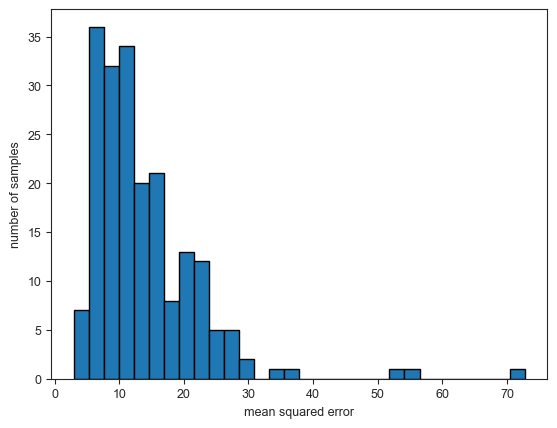

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [14]:
data = np.array(mse_list)
hist, bins = np.histogram(data, bins=30)
plt.figure()
plt.hist(data, bins=bins, edgecolor='black')
plt.xlabel('mean squared error')
plt.ylabel('number of samples')
plt.savefig(os.path.join(resultdir,'ErrorHistogram.pdf'))
plt.show()
plt.close